# Statistical Analysis

This notebook contains routines for analyzing the output of keypoint-MoSeq.

## Setup

We assume you have already have keypoint-MoSeq outputs that are organized as follows.
```
<project_dir>/               ** current working directory
└── <model_name>/            ** model directory
    ├── results.h5           ** model results
    └── grid_movies/         ** [Optional] grid movies folder
```
Use the code below to enter in your project directory and model name.

In [1]:
import keypoint_moseq as kpms

project_dir='demo_project/' # the full path to the project directory
model_name='2023_08_01-10_16_25' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)

## Assign Groups

The goal of this step is to assign group labels (such as "mutant" or "wildtype") to each recording. These labels are important later for performing group-wise comparisons.
- The code below will first create a new file called `{project_dir}/index.csv` (unless it already exists).
- The file stores a table with recording names in the first column and group labels in the second column.
- Next, the code will launch an interactive widget for editing the table. To use the widget:
    - Click cells in the "group" and enter new group labels.
    - Hit `Save group info` when you're done.
- **If the widget doesn't appear**, you can alternatively edit the file directly in Excel or LibreOffice Calc.

In [2]:
kpms.interactive_group_setting(project_dir, model_name)

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'file name', ...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

## Generate dataframes

Generate a pandas dataframe called `moseq_df` that contains syllable labels and kinematic information for each frame across all the recording sessions. 

In [15]:
moseq_df = kpms.compute_moseq_df(project_dir, model_name, smooth_heading=True) 
moseq_df

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,245.691668,210.796020,-1.217558,0.000000,0.000000,7,0,default,True
1,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,246.797705,208.926666,-1.217558,-0.079308,65.161529,7,1,default,False
2,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,246.880092,208.750297,-1.227725,-0.160751,5.839875,7,2,default,False
3,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,247.338747,206.761270,-1.240335,-0.246197,61.236711,7,3,default,False
4,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exa...,248.073132,205.021514,-1.240335,-0.336099,56.652130,7,4,default,False
...,...,...,...,...,...,...,...,...,...,...
643906,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,217.514933,196.355583,0.193480,-0.618441,565.377392,12,53618,default,False
643907,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,202.928966,183.149695,0.086206,-0.318911,590.280706,12,53619,default,False
643908,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,187.950492,169.656667,0.193808,-0.126241,604.793226,12,53620,default,False
643909,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,173.977080,155.679578,0.302726,-0.026824,592.919672,12,53621,default,False


In [5]:
import os
save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, 'moseq_df.csv'), index=False)
print('Saved `moseq_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to demo_project/2023_08_01-10_16_25


Next generate a dataframe called `stats_df` that contains summary statistics for each syllable in each recording session, such as its usage frequency and its distribution of kinematic parameters.

In [16]:
stats_df = kpms.compute_stats_df(
    project_dir,
    model_name,
    moseq_df, 
    min_frequency=0.005,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30)                    # frame rate of the video from which keypoints were inferred

stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max,frequency,duration
0,control,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_ex...,0,-0.185726,1.675327,-3.141268,3.141216,0.006244,5.969984,-188.391070,188.423102,23.873621,18.251097,0.052929,250.661913,0.193452,1.278718
1,control,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_ex...,1,-0.186075,1.545966,-3.138770,3.141024,-0.047082,9.326394,-188.077053,3.634033,39.028218,31.174287,0.688662,216.440283,0.113839,0.884532
2,control,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_ex...,2,-0.270518,1.744452,-3.141173,3.140562,-0.237998,12.575613,-187.851585,188.203382,61.339926,45.208260,0.699143,249.923269,0.130208,0.846095
3,control,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_ex...,3,0.300797,1.392815,-3.139225,3.140805,-0.005278,10.043521,-188.285953,188.290531,35.085909,27.308359,0.488694,234.898832,0.112351,1.552759
4,control,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_ex...,4,0.004180,1.850509,-3.136158,3.138170,0.292483,13.734939,-188.161345,188.074944,38.752501,31.086649,0.536752,204.338343,0.068452,1.219203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,default,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,12,-0.343568,2.113718,-3.134325,2.868795,0.316647,34.036682,-185.414342,183.651273,87.411189,123.365809,3.599279,604.793226,0.012248,0.233333
164,default,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,13,-0.249593,1.876115,-3.057123,3.120467,-0.005688,20.504012,-187.255415,185.818223,37.320398,24.154216,3.065904,152.797193,0.015130,0.404762
165,default,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,14,-0.832416,1.667609,-3.016993,3.104799,0.228053,8.036534,-9.531238,185.992484,24.555842,13.692978,1.042922,86.459174,0.013689,0.961404
166,default,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_mos...,15,-0.285527,1.523412,-2.951821,3.047571,0.177886,1.131052,-2.484323,2.431322,34.447936,20.638749,1.715828,135.602207,0.008646,0.544444


In [11]:
set(list(stats_df['group']))

{'control', 'control\n', 'default'}

In [6]:
import os
save_dir = os.path.join(project_dir, model_name)
stats_df.to_csv(os.path.join(save_dir, 'stats_df'), index=False)
print('Saved `stats_df` dataframe to', save_dir)

Saved `stats_df` dataframe to demo_project/2023_08_01-10_16_25


##  Label syllables

The goal of this step is to inspect each syllable and give it a name (such as "rear up" or "walk slowly").
- The code below will first creates a new file called `{project_dir}/{model_name}/syll_info.csv` (unless it already exists).
- The file stores a table three columns: "syllable", "label", and "short_description".
- Next, the code will launch an interactive widget for editing the table. To use the widget:
    - Select a syllable from the dropdown to display its grid movie.
    - Enter a name into the `label` column of the table (and optionally a short description too).
    - When you are all done, hit `Save syllable info` at the bottom of the table.
- **If the widget doesn't appear**, you can alternatively edit the file directly in Excel or LibreOffice Calc.

In [7]:
kpms.label_syllables(project_dir, model_name, moseq_df) 

Row
    [0] Column
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] ParamFunction(function, _pane=Video, defer_load=False)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syll', ...}, value=    syllable  ..., widths={'syllable': 5})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

## Compare between groups

Test for statistically significant differences between groups of recordings. The code below takes a syllable property (e.g. frequency or duration), plots its disribution for each syllable across for each group, and also tests whether the property differs significantly between groups. The results are summarized in a plot that is saved to `{project_dir}/{model_name}/analysis_figures`.

There are two options for setting the order of syllables along the x-axis. When `order='stat'`, syllables are sorted by the mean value of the statistic. When `order='diff'`, syllables are sorted by the magnitude of difference between two groups that are determined by the `ctrl_group` and `exp_group` keywords. Note `ctrl_group` and `exp_group` are not related to significance testing.

/Users/calebweinreb/Dropbox (HMS)/caleb weinreb/PROJECTS/MOUSE_SURVEILANCE/22_3_1_keypoint_MOSEQ/official_pipelines/keypoint-moseq/keypoint_moseq/analysis.py:1176: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to demo_project/2023_08_01-10_16_25/figures/frequency_stat_stats.png


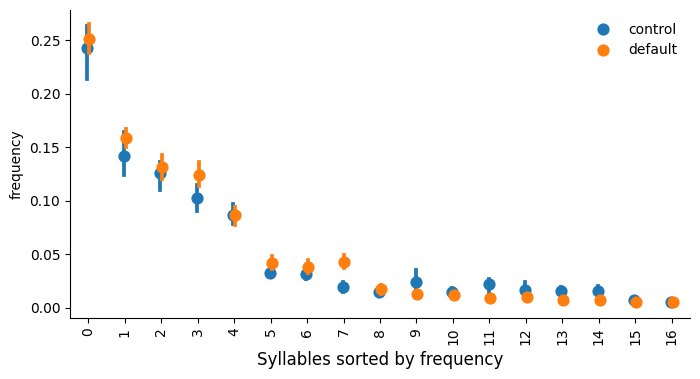

In [17]:
kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=0.05,      # significance threshold
    stat='frequency', # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference ("diff")
    ctrl_group='a',   # name of the control group for statistical testing
    exp_group='b',    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    groups=stats_df['group'].unique(), # groups to be plotted
);

### Transition matrices
Generate heatmaps showing the transition frequencies between syllables.

Group(s): control, default
Saved figure to demo_project/2023_08_01-10_16_25/figures/transition_matrices.png


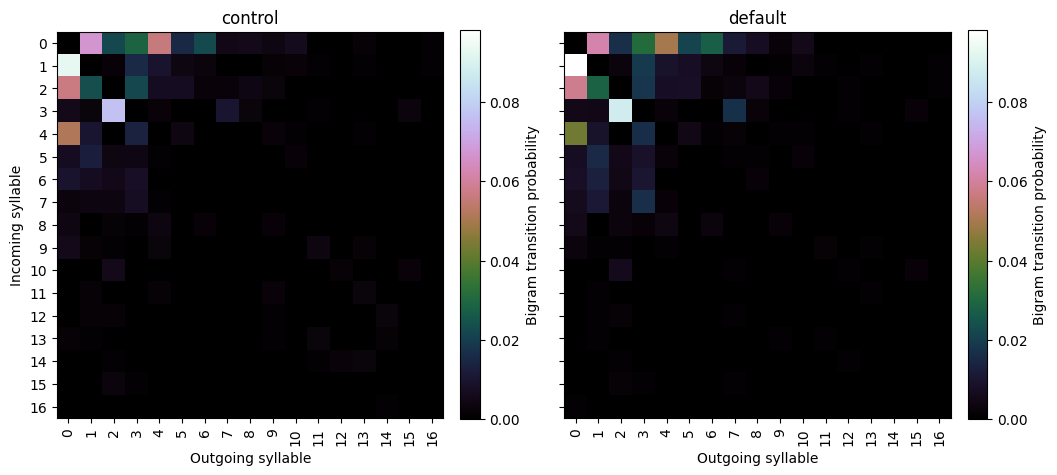

In [18]:
normalize='bigram' # normalization method ("bigram", "rows" or "columns")

trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
    project_dir, model_name, normalize=normalize,
    min_frequency=0.005 # minimum syllable frequency to include
)    

kpms.visualize_transition_bigram(
    project_dir, model_name, groups, trans_mats, syll_include, normalize=normalize, 
    show_syllable_names=True # label syllables by index (False) or index and name (True)
)

### Syllable Transition Graph
Render transition rates in graph form, where nodes represent syllables and edges represent transitions between syllables, with edge showing transition rate for each pair of syllables (secifically the max of the two transition rates in each direction). The code below first generates a transition graph for each single group, and then generates a difference-graph for each pair of groups.

Saved figure to demo_project/2023_08_01-10_16_25/figures/transition_graphs.png


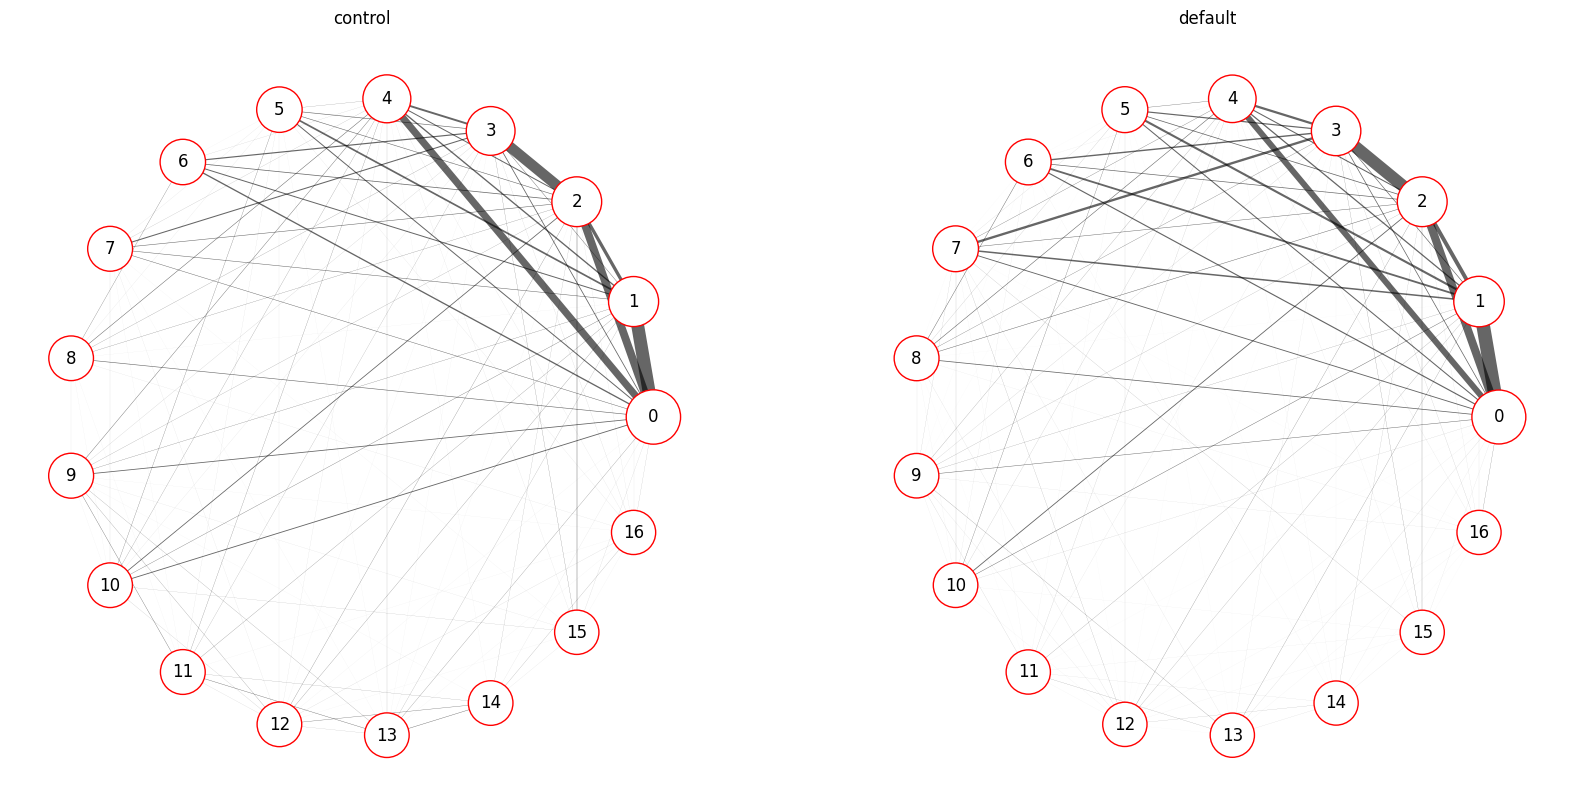

In [19]:
kpms.plot_transition_graph_group(
    project_dir, model_name, 
    groups, trans_mats, usages, syll_include, 
    layout='circular',        # transition graph layout ("circular" or "spring")
    show_syllable_names=False # label syllables by index (False) or index and name (True)
)

Saved figure to demo_project/2023_08_01-10_16_25/figures/transition_graphs_diff.png


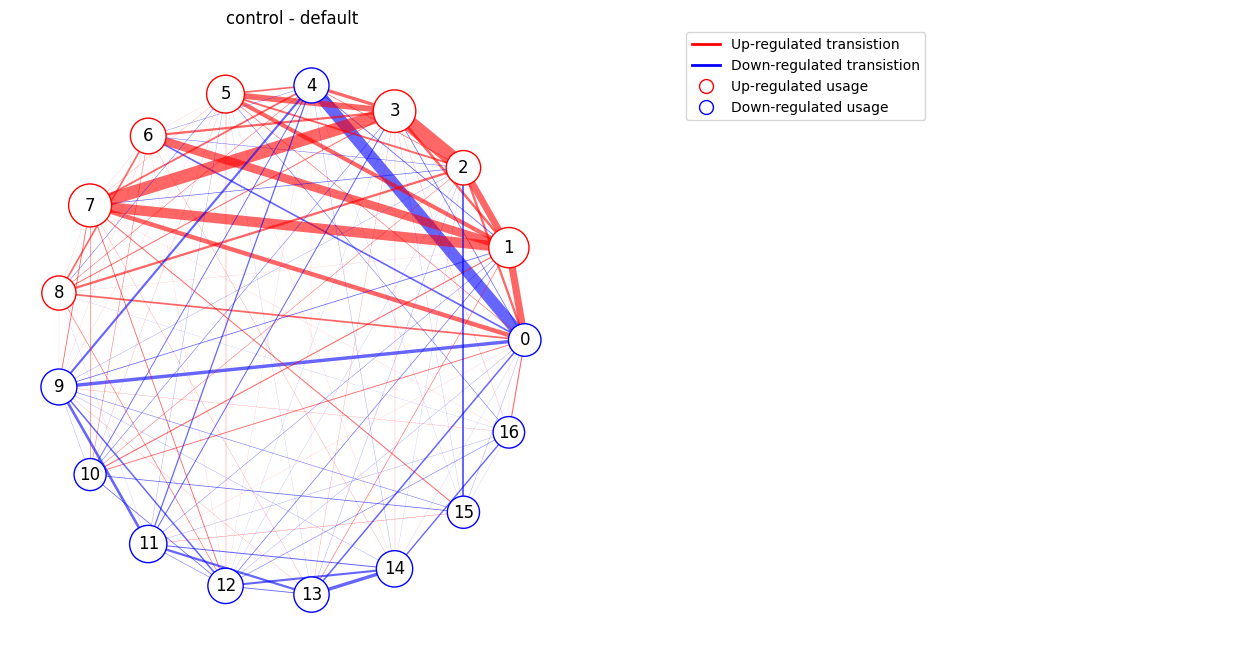

In [20]:
kpms.plot_transition_graph_difference(project_dir, model_name, 
                                      groups, trans_mats, usages, syll_include, 
                                      layout='circular') # transition graph layout ("circular" or "spring")